In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Generating Synthetic data with Mackey-Glass

In [567]:
#PARAMETERS 
gamma = 1
beta = 2
tau = 2
n = 9.65

stepsize = 0.001
tmax = 100
numsteps = int(tmax/stepsize)

init = 0.5

In [568]:
def dxdt(x, xt, gamma, beta, n, verbose=False):
    if verbose:
        print "x", x
        print "xt", xt
        print "gamma", gamma
        print "beta", beta
        print "n", n
        print
    return beta*(xt/(1+xt**n))-gamma*x

In [569]:
data = [init]*(1+int(tau*(1/stepsize)))
for i in range(numsteps):
    step = dxdt(data[-1], data[-(1+int(tau*(1/stepsize)))], gamma, beta, n, False)*stepsize
    data.append(data[-1]+step)

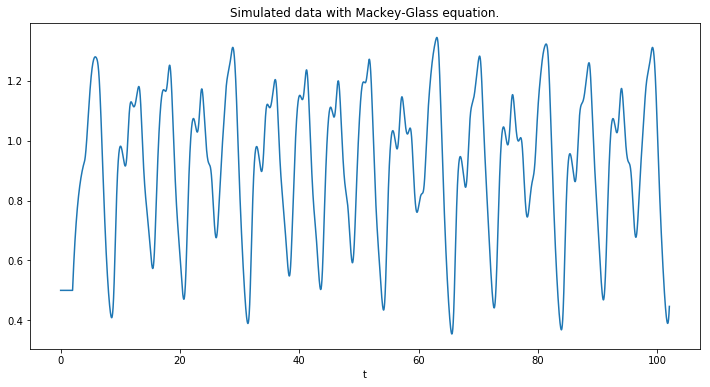

In [572]:
plt.figure(figsize=(12,6))
plt.plot([i*stepsize for i in range(len(data))], data)
plt.title("Simulated data with Mackey-Glass equation.")
plt.xlabel("t")

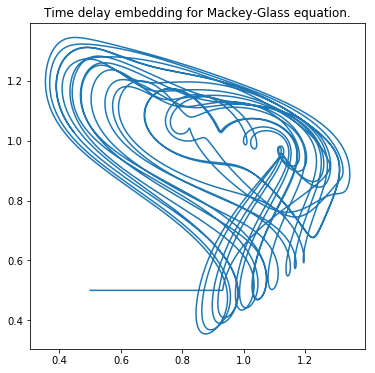

In [573]:
plt.figure(figsize=(6,6))
plt.plot(data[int(tau*(1/stepsize)):],data[:-1*int(tau*(1/stepsize))])
plt.title("Time delay embedding for Mackey-Glass equation.")

# Sampling data from time series data

Using values from t-100 to t in order to predict a value at t+50.

In [574]:
raw = np.array(data[(int(tau*(1/stepsize))+1)*4:])

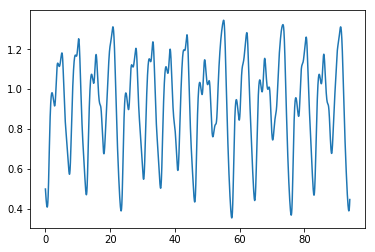

In [575]:
plt.plot([i*stepsize for i in range(len(raw))], raw)

In [576]:
d = 100
feature_resolution = 0.006
leap = int(feature_resolution/stepsize)
prediction_target = 20
print d*feature_resolution, "time as feature"

0.6 time as feature


In [577]:
indexes = [j*leap for j in range(d)]
pred_index = (d+prediction_target)*leap

In [578]:
# Generating data
x = []
y = []
for i in range(len(raw)-pred_index):
    x.append(raw[[j*leap+i for j in range(d)]])
    y.append(raw[i+pred_index])
x = np.array(x)
y = np.array(y)

In [579]:
# Shuffling
index = range(len(y))
np.random.shuffle(index)
y = y[index]
x = x[index, :]

In [580]:
# splitting data
train = 0.7
valid = 0.8
test = 1.0

y_train = y[:int(len(y)*train)]
x_train = x[:int(len(y)*train), :]

y_valid = y[int(len(y)*train):int(len(y)*valid)]
x_valid = x[int(len(y)*train):int(len(y)*valid), :]

y_test = y[int(len(y)*valid):]
x_test = x[int(len(y)*valid):, :]

print x_train.shape, x_valid.shape, x_test.shape

(65293, 100) (9328, 100) (18656, 100)


In [620]:
x_unshuffled = []
for i in range(len(raw)-pred_index):
    x_unshuffled.append(raw[[j*leap+i for j in range(d)]])

In [621]:
x_unshuffled = np.array(x_unshuffled)

# Prediction with simple LASSO.

In [582]:
from sklearn import linear_model

In [583]:
alphas = [10**(-1*i) for i in range(1,10)]

In [584]:
MSEs = []
for a in alphas:
    clf = linear_model.Lasso(alpha=a)
    clf.fit(x_train,y_train)
    p = clf.predict(x_valid)
    MSEs.append(np.mean((p-y_valid)**2))

minimum MSE achieved at 0.0001


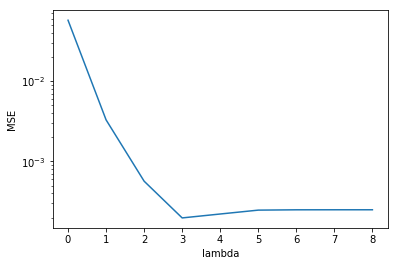

In [585]:
plt.plot(range(len(MSEs)), MSEs)
plt.yscale("log")
plt.ylabel("MSE")
plt.xlabel("lambda")
print "minimum MSE achieved at", alphas[np.argmin(MSEs)]

In [586]:
clf = linear_model.Lasso(alpha=0.0001)
clf.fit(x_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [587]:
print "W sparcity:", len([i for i in clf.coef_ if i!=0])*1.0/len(clf.coef_)

W sparcity: 0.29


In [612]:
imputed_signal = clf.predict(x_unshuffled)
p = clf.predict(x_test)

0.000200177099845


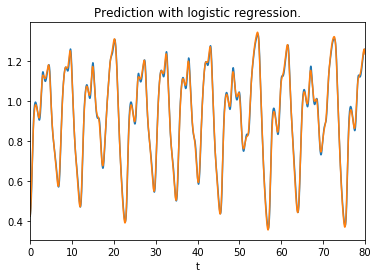

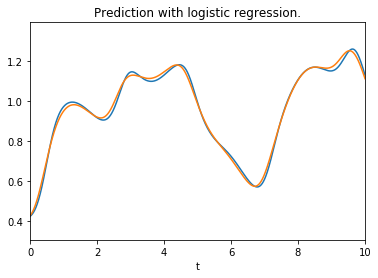

In [613]:
plt.figure()
plt.plot([i*stepsize for i in range(len(imputed_signal))], imputed_signal)
plt.plot([i*stepsize for i in range(len(imputed_signal))], raw[pred_index:])
plt.xlim(0,80)
plt.xlabel("t")
plt.title("Prediction with logistic regression.")

plt.figure()
plt.plot([i*stepsize for i in range(len(imputed_signal))], imputed_signal)
plt.plot([i*stepsize for i in range(len(imputed_signal))], raw[pred_index:])
plt.xlim(0,10)
plt.xlabel("t")
plt.title("Prediction with logistic regression.")

print np.mean((p-y_test)**2)

In [590]:
lim= int(40/stepsize)
print lim
prediction1 = np.zeros(lim+pred_index)
prediction1[:pred_index] = raw[:pred_index]
count =0
for i in range(lim):
    p = clf.predict([prediction1[[j*leap+i for j in range(d)]]])
    prediction1[pred_index+i] = p[0]
    count += 1

40000


(0, 2)

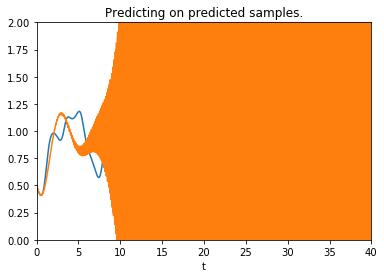

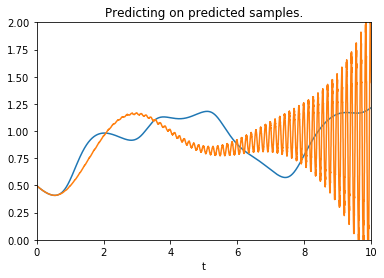

In [594]:
plt.figure()
plt.plot([i*stepsize for i in range(len(prediction1))], raw[:len(prediction1)])
plt.plot([i*stepsize for i in range(len(prediction1))], prediction1)
plt.title("Predicting on predicted samples.")
plt.xlim(0,40)
plt.xlabel("t")
plt.ylim(0,2)

plt.figure()
plt.plot([i*stepsize for i in range(len(prediction1))], raw[:len(prediction1)])
plt.plot([i*stepsize for i in range(len(prediction1))], prediction1)
plt.title("Predicting on predicted samples.")
plt.xlim(0,10)
plt.xlabel("t")
plt.ylim(0,2)

# Predicting with DNN

In [600]:
from __future__ import absolute_import
from __future__ import division

import os
import urllib
import tensorflow as tf

In [601]:
# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=100)]

In [608]:
# Build 3 layer DNN with 10, 20, 10 units respectively.
estimator = tf.contrib.learn.DNNRegressor(feature_columns=feature_columns,
                                          hidden_units=[15, 10, 5],
                                          optimizer=tf.train.AdamOptimizer())
    #,config=tf.contrib.learn.RunConfig(save_checkpoints_secs=10))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13b9d0b50>, '_model_dir': '/var/folders/10/pblndpkn3nn640n4hh6r6gg00000gn/T/tmpdyIEnd', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}


In [609]:
def feed_validation_samples():
    return tf.constant(x_valid), tf.constant(y_valid)

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    input_fn = feed_validation_samples,
    early_stopping_rounds=50)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [631]:
def feed_training_samples():
    return tf.constant(x_train), tf.constant(y_train)

tes = estimator.fit(input_fn=feed_training_samples, steps=100)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/10/pblndpkn3nn640n4hh6r6gg00000gn/T/tmpdyIEnd/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into /var/folders/10/pblndpkn3nn640n4hh6r6gg00000gn/T/tmpdyIEnd/model.ckpt.
INFO:tensorflow:loss = 0.00017971, step = 4001
INFO:tensorflow:Saving checkpoints for 4100 into /var/folders/10/pblndpkn3nn640n4hh6r6gg00000gn/T/tmpdyIEnd/model.ckpt.
INFO:tensorflow:Loss for final step: 0.000116222.


In [632]:
def feed_testing_samples():
    return tf.constant(x_test), None

prediction = estimator.predict_scores(input_fn=feed_testing_samples)
p = np.array(list(prediction))

INFO:tensorflow:Restoring parameters from /var/folders/10/pblndpkn3nn640n4hh6r6gg00000gn/T/tmpdyIEnd/model.ckpt-4100


In [633]:
def feed_testing_samples2():
    return tf.constant(x_unshuffled), None

prediction = estimator.predict_scores(input_fn=feed_testing_samples2)
imputed_signal2 = np.array(list(prediction))

INFO:tensorflow:Restoring parameters from /var/folders/10/pblndpkn3nn640n4hh6r6gg00000gn/T/tmpdyIEnd/model.ckpt-4100


In [634]:
print np.mean((p-y_test)**2)

0.000117838051279


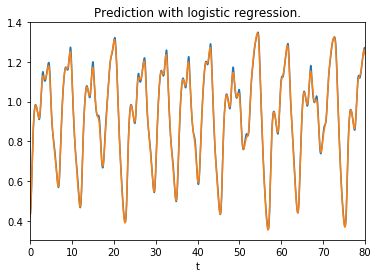

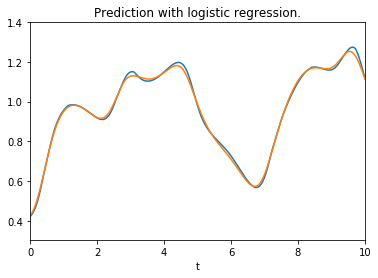

In [635]:
plt.figure()
plt.plot([i*stepsize for i in range(len(imputed_signal2))], imputed_signal2)
plt.plot([i*stepsize for i in range(len(imputed_signal2))], raw[pred_index:])
plt.xlim(0,80)
plt.xlabel("t")
plt.title("Prediction with DNN.")

plt.figure()
plt.plot([i*stepsize for i in range(len(imputed_signal2))], imputed_signal2)
plt.plot([i*stepsize for i in range(len(imputed_signal2))], raw[pred_index:])
plt.xlim(0,10)
plt.xlabel("t")
plt.title("Prediction with DNN.")

In [ ]:
lim= int(1/stepsize)
print lim
prediction1 = np.zeros(lim+pred_index)
prediction1[:pred_index] = raw[:pred_index]
count = 0
for i in range(lim):
    f = lambda:(tf.constant(np.array([prediction1[[j*leap+i for j in range(d)]]])), None)
    p = estimator.predict_scores(input_fn=f)
    prediction1[pred_index+i] = list(p)[0]
    count += 1

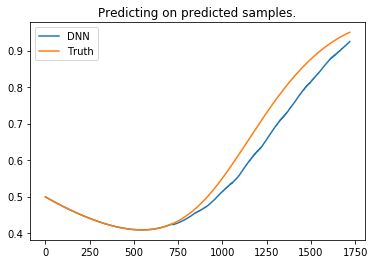

In [640]:
plt.figure()
plt.plot(range(len(prediction1)), raw[:len(prediction1)], label="Truth")
plt.plot(range(len(prediction1)), prediction1, label="DNN")
plt.legend()

plt.title("Predicting on predicted samples.")

# Using LSTM to predict

In [644]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [650]:
lstm_x_train = np.expand_dims(x_train,3)
lstm_x_valid = np.expand_dims(x_valid,3)
lstm_x_test = np.expand_dims(x_test,3)

In [653]:
lstm_x_train.shape

(65293, 100, 1)

In [660]:
model = Sequential()
model.add(LSTM(4, input_shape=(100, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [662]:
model.fit(lstm_x_train[:100], y_train[:100], epochs=1, batch_size=1, verbose=0)

In [663]:
model.predict(lstm_x_test[:10])

array([[ 1.02207708],
       [ 1.03844416],
       [ 0.76640832],
       [ 0.80238712],
       [ 0.55057281],
       [ 0.7036407 ],
       [ 1.1064446 ],
       [ 0.39846471],
       [ 0.52567244],
       [ 0.9335016 ]], dtype=float32)

# Summary

Synthesized data is too simple for deep-learning to have an advantage over simple LASSO regression. When samples are generated from high resolution data, LASSO regression can almost pefectly fit the synthesized data. I need to work with some real, non-periodic, and complex data so that DNN has an advantage over.